In [1]:
import os
import pathlib
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Use the matplotlib plotting styles
CURR_PATH = pathlib.Path().parent
MPLSTYLE = CURR_PATH.joinpath("plotstyle.mplstyle")
plt.style.use(MPLSTYLE)

In [3]:
MAP_CHARGE = {14: "neutrino", -14: "antineutrino"}

In [4]:
def file_reader(experiment,name,smear_corr='',clipped = 0):   
    x_edges = np.logspace(-4,0,30)
    Q2_edges = np.array([4,10**1,10**2,10**3,10**4,10**5])
    ####################################################
    ####################################################
    #first parse data
    x_lower = np.array([])
    x_upper = np.array([])
    Enu_lower = np.array([])
    Enu_upper = np.array([])
    q2_lower = np.array([])
    q2_upper = np.array([])
    stat_error = np.array([])
    sys_error = np.array([])
    diffxsec = np.array([])
    N = np.array([])
    xavg = np.array([])
    qavg = np.array([])
    Enuavg = np.array([])
    xsec = np.array([])
    frac_variance = np.array([])
    frac_variance_theta = np.array([])
    frac_variance_Elepton = np.array([])
    frac_variance_Ehadron = np.array([])
    MCsamples = np.array([])
    
    if clipped == 0:
        readfile = os.path.join(os.getcwd(),name)
        
    with open(readfile,'r') as f:
        lines = f.readlines()
        for il,line in enumerate(lines):            
            if il <= 1: 
                continue
            else:
                sp = line.split()
                try:
                    x_lower = np.append(x_lower,float(sp[0]));x_upper = np.append(x_upper,float(sp[1]))
                except:
                    pdb.set_trace()
                xavg = np.append(xavg,float(sp[2]));

                q2_lower = np.append(q2_lower,float(sp[3]));q2_upper = np.append(q2_upper,float(sp[4]))
                qavg = np.append(qavg, float(sp[5]))
                
                Enu_lower = np.append(Enu_lower , float(sp[6]));Enu_upper = np.append(Enu_upper , float(sp[7]))
                Enuavg = np.append(Enuavg , float(sp[8]))
                
                diffxsec = np.append(diffxsec , float(sp[9]))

                N = np.append(N,float(sp[10]))
                stat_error = np.append(stat_error,float(sp[11]))
                sys_error = np.append(sys_error,float(sp[12]))
                frac_variance_theta = np.append(frac_variance_theta , float(sp[13]))
                frac_variance_Elepton = np.append(frac_variance_Elepton , float(sp[14]))
                frac_variance_Ehadron = np.append(frac_variance_Ehadron , float(sp[15]))
                MCsamples = np.append(MCsamples , float(sp[16]))
                
    return x_lower , x_upper , xavg , q2_lower , q2_upper , qavg , Enu_lower , Enu_upper , Enuavg , diffxsec , N , stat_error , sys_error  , frac_variance_theta,frac_variance_Elepton,frac_variance_Ehadron,MCsamples

In [5]:
def make_plots(experiment,neutrino,folder,error):
    #prepare plotting
    csfont = {"size" : 20}
    matplotlib.rc('font', **csfont)
    
    #sets up charm vs inclusive
    save_folder = folder.upper();
    append_save = folder
    
    #selects nu or nubar depending on neutrino type
    neutrino_string = 'nu' if neutrino > 0 else 'nub'
    file = os.path.join(os.getcwd() , save_folder,experiment,'clipped_nan','clipped_nan_binned_sysevents_%s_%s_%s.txt' %(experiment,append_save,neutrino_string))
    
    #read in data
    x_lower , x_upper , xavg , q2_lower , q2_upper , q2avg , _ , _ , _ , _ , N_array , stat_error , sys_error , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron,_ =\
    file_reader(experiment,file)
    
    ####################################
    
    #Prepare figure
    #2x2 subplot with size 32x16. q2_regions correspond to plot_locs in 2x2 array
    fig , axs = plt.subplots(
        nrows=1,
        ncols=3,
        sharey=True,
        figsize=(4 * 3, 4.5),
    )
    q2_region = [1e1, 1e3]

    for idx, ax in enumerate(axs.flat):
        locs = np.where((q2_lower >= q2_region[0]) & (q2_upper<=q2_region[1]))
        x_plot = np.exp((np.log(x_lower[locs[0]])+np.log(x_upper[locs[0]]))/2)
        q2_plot = np.exp((np.log(q2_lower[locs[0]])+np.log(q2_upper[locs[0]]))/2)

        #x_ploterr is width of bin
        x_ploterr_lower = x_plot - x_lower[locs[0]]
        x_ploterr_upper = x_upper[locs[0]] - x_plot
        x_ploterr = [x_ploterr_lower,x_ploterr_upper]

        if idx == 0:
            y_error = stat_error[locs[0]]
            suptitle = r"\rm{Event rate with Stat. Error}"
        elif idx == 1:
            y_error = sys_error[locs[0]]
            suptitle = r"\rm{Event rate with Syst. Error}"
        elif idx == 2:
            y_error = np.sqrt(stat_error[locs[0]]**2 +sys_error[locs[0]]**2)
            suptitle = r"\rm{Event rate with Stat. \& Syst. Error}"
        else:
            raise ValueError("Error type not defined!!")

        ax.errorbar(x_plot , N_array[locs[0]],xerr = x_ploterr,yerr = y_error,linestyle = 'none',capsize = 7)

        ax.set_xlabel(r'$x$')
        ax.set_title(suptitle)
        ax.grid(alpha = 0.1, which = 'both')
        ax.set_xscale('log')
        ax.set_xlim(5e-3, 1.2)
        
        if neutrino < 0:
            neutrino_string_label = r'\bar{\nu}'
        else:
            neutrino_string_label = r'\nu'

        # TODO: Make modular
        if idx == 0:
            ax.text(
                0.12,
                0.85, 
                r"$10~\rm{GeV}^2 \leq Q^2 \leq 10^2~\rm{GeV}^2$",
                bbox=dict(boxstyle="round", ec="k", fc="w"),
                fontsize=15,
                transform=ax.transAxes,
            )
            ax.set_ylabel(r"$N_{\bar{\nu}} ( ~ \bar{\nu}_{\mu} N \rightarrow \mu^+ X )~\rm{at}~\rm{FASER}\nu 2$")
        
        #Change yscale here and ylim. 
        #You will probably need to change this for other experiments (especially run3 experiments)
        ax.set_yscale('log')
        ax.set_ylim(1e2, 1e4)

    fig.subplots_adjust(wspace=5e-2)
    output_name = f"Event_Rate_{experiment}_{MAP_CHARGE[neutrino]}.pdf"
    fig.savefig(output_name, bbox_inches="tight", dpi=350)

In [32]:
def make_updated_plots(experiment,neutrino,folder,error):
    #prepare plotting
    csfont = {"size" : 20}
    matplotlib.rc('font', **csfont)
    
    #sets up charm vs inclusive
    save_folder = folder.upper();
    append_save = folder
    
    neutrino = -14
    #selects nu or nubar depending on neutrino type
    neutrino_string = 'nu' if neutrino > 0 else 'nub'
    file = os.path.join(os.getcwd() , save_folder,experiment,'clipped_nan','clipped_nan_binned_sysevents_%s_%s_%s.txt' %(experiment,append_save,neutrino_string))
    
    #read in data
    x_lower , x_upper , xavg , q2_lower , q2_upper , q2avg , _ , _ , _ , _ , N_array , stat_error , sys_error , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron,_ =\
    file_reader(experiment,file)
    
    ####################################
    
    #Prepare figure
    #2x2 subplot with size 32x16. q2_regions correspond to plot_locs in 2x2 array
    fig , axs = plt.subplots(
        nrows=1,
        ncols=3,
        sharey=True,
        figsize=(4 * 3, 4.5),
    )
    q2_region = [1e1, 1e2]

    for idx, ax in enumerate(axs.flat):
        locs = np.where((q2_lower >= q2_region[0]) & (q2_upper<=q2_region[1]))
        x_plot = np.exp((np.log(x_lower[locs[0]])+np.log(x_upper[locs[0]]))/2)
        q2_plot = np.exp((np.log(q2_lower[locs[0]])+np.log(q2_upper[locs[0]]))/2)

        #x_ploterr is width of bin
        x_ploterr_lower = x_plot - x_lower[locs[0]]
        x_ploterr_upper = x_upper[locs[0]] - x_plot
        x_ploterr = [x_ploterr_lower,x_ploterr_upper]

        if idx == 0:
            y_error = stat_error[locs[0]]
            suptitle = r"\rm{Event rate with Stat. Error}"
        elif idx == 1:
            y_error = sys_error[locs[0]]
            suptitle = r"\rm{Event rate with Syst. Error}"
        elif idx == 2:
            y_error = np.sqrt(stat_error[locs[0]]**2 +sys_error[locs[0]]**2)
            suptitle = r"\rm{Event rate with Stat. \& Syst. Error}"
        else:
            raise ValueError("Error type not defined!!")

        spacing = x_plot[1] - x_plot[0]
        ax.step(
            [x_plot[0] - 0.5 * spacing] + list(x_plot) + [x_plot[-1] + 20 * spacing],
            [N_array[locs[0]][0]] + list(N_array[locs[0]]) + [N_array[locs[0]][-1]], 
            color="C0", 
            where="mid", 
            lw=0.95,
        )
        min_err = list(N_array[locs[0]] - y_error)
        max_err = list(N_array[locs[0]] + y_error)
        ax.fill_between(
            [x_plot[0] - 0.5 * spacing] + list(x_plot) + [x_plot[-1] + 20 * spacing],
            [min_err[0]] + min_err + [min_err[-1]],
            [max_err[0]] + max_err + [max_err[-1]],
            color="C0",
            alpha=0.3,
            step="mid",
            label=r"$\bar{\nu}_\mu$",
        )

#         ax.set_xlabel(r'$x$')
#         ax.set_title(suptitle)
#         ax.grid(alpha = 0.1, which = 'both')
#         ax.set_xscale('log')
#         ax.set_xlim(5e-3, 1.2)
        
#         if neutrino < 0:
#             neutrino_string_label = r'\bar{\nu}'
#         else:
#             neutrino_string_label = r'\nu'

#         # TODO: Make modular
#         if idx == 0:
#             ax.text(
#                 0.12,
#                 0.85, 
#                 r"$10~\rm{GeV}^2 \leq Q^2 \leq 10^2~\rm{GeV}^2$",
#                 bbox=dict(boxstyle="round", ec="k", fc="w"),
#                 fontsize=15,
#                 transform=ax.transAxes,
#             )
#             ax.set_ylabel(r"$N_{\bar{\nu}} ( ~ \bar{\nu}_{\mu} N \rightarrow \mu^+ X )~\rm{at}~\rm{FASER}\nu 2$")
        
#         #Change yscale here and ylim. 
#         #You will probably need to change this for other experiments (especially run3 experiments)
#         ax.set_yscale('log')
#         ax.set_ylim(1e2, 1e4)
        
        
    ##### NEUTRINO
    neutrino = 14
    #selects nu or nubar depending on neutrino type
    neutrino_string = 'nu' if neutrino > 0 else 'nub'
    file = os.path.join(os.getcwd() , save_folder,experiment,'clipped_nan','clipped_nan_binned_sysevents_%s_%s_%s.txt' %(experiment,append_save,neutrino_string))
    
    #read in data
    x_lower , x_upper , xavg , q2_lower , q2_upper , q2avg , _ , _ , _ , _ , N_array , stat_error , sys_error , frac_sys_theta , frac_sys_Elepton , frac_sys_Ehadron,_ =\
    file_reader(experiment,file)
    
    ####################################

    for idx, ax in enumerate(axs.flat):
        locs = np.where((q2_lower >= q2_region[0]) & (q2_upper<=q2_region[1]))
        x_plot = np.exp((np.log(x_lower[locs[0]])+np.log(x_upper[locs[0]]))/2)
        q2_plot = np.exp((np.log(q2_lower[locs[0]])+np.log(q2_upper[locs[0]]))/2)

        #x_ploterr is width of bin
        x_ploterr_lower = x_plot - x_lower[locs[0]]
        x_ploterr_upper = x_upper[locs[0]] - x_plot
        x_ploterr = [x_ploterr_lower,x_ploterr_upper]

        if idx == 0:
            y_error = stat_error[locs[0]]
            suptitle = r"\rm{Event rate with Stat. Error}"
        elif idx == 1:
            y_error = sys_error[locs[0]]
            suptitle = r"\rm{Event rate with Syst. Error}"
        elif idx == 2:
            y_error = np.sqrt(stat_error[locs[0]]**2 +sys_error[locs[0]]**2)
            suptitle = r"\rm{Event rate with Stat. \& Syst. Error}"
        else:
            raise ValueError("Error type not defined!!")

        spacing = x_plot[1] - x_plot[0]
        ax.step(
            [x_plot[0] - 0.5 * spacing] + list(x_plot) + [x_plot[-1] + 20 * spacing],
            [N_array[locs[0]][0]] + list(N_array[locs[0]]) + [N_array[locs[0]][-1]], 
            color="C1", 
            where="mid", 
            lw=0.95,
        )
        min_err = list(N_array[locs[0]] - y_error)
        max_err = list(N_array[locs[0]] + y_error)
        ax.fill_between(
            [x_plot[0] - 0.5 * spacing] + list(x_plot) + [x_plot[-1] + 20 * spacing],
            [min_err[0]] + min_err + [min_err[-1]],
            [max_err[0]] + max_err + [max_err[-1]],
            color="C1",
            alpha=0.3,
            step="mid",
            label=r"$\nu_\mu$",
        )

        ax.set_xlabel(r'$x$')
        ax.set_title(suptitle)
        ax.grid(alpha = 0.1, which = 'both')
        ax.set_xscale('log')
        ax.set_xlim(5e-3, 1.2)
        
        if neutrino < 0:
            neutrino_string_label = r'\bar{\nu}'
        else:
            neutrino_string_label = r'\nu'

        # TODO: Make modular
        if idx == 0:
            ax.text(
                0.12,
                0.91, 
                r"$10~\rm{GeV}^2 \leq Q^2 \leq 10^2~\rm{GeV}^2$",
                bbox=dict(boxstyle="round", ec="k", fc="w"),
                fontsize=15,
                transform=ax.transAxes,
            )
            ax.set_ylabel(r"$N_{\bar{\nu}} ( \bar{\nu}_{\mu} / \nu_\mu N \rightarrow \mu^\pm X )~\rm{at}~\rm{FASER}\nu 2$")
            ax.legend(loc="lower center")
        
        #Change yscale here and ylim. 
        #You will probably need to change this for other experiments (especially run3 experiments)
        ax.set_yscale('log')
        ax.set_ylim(1e2, 1e4)

    fig.subplots_adjust(wspace=5e-2)
    output_name = f"Event_Rate_{experiment}.pdf"
    fig.savefig(output_name, bbox_inches="tight", dpi=350)

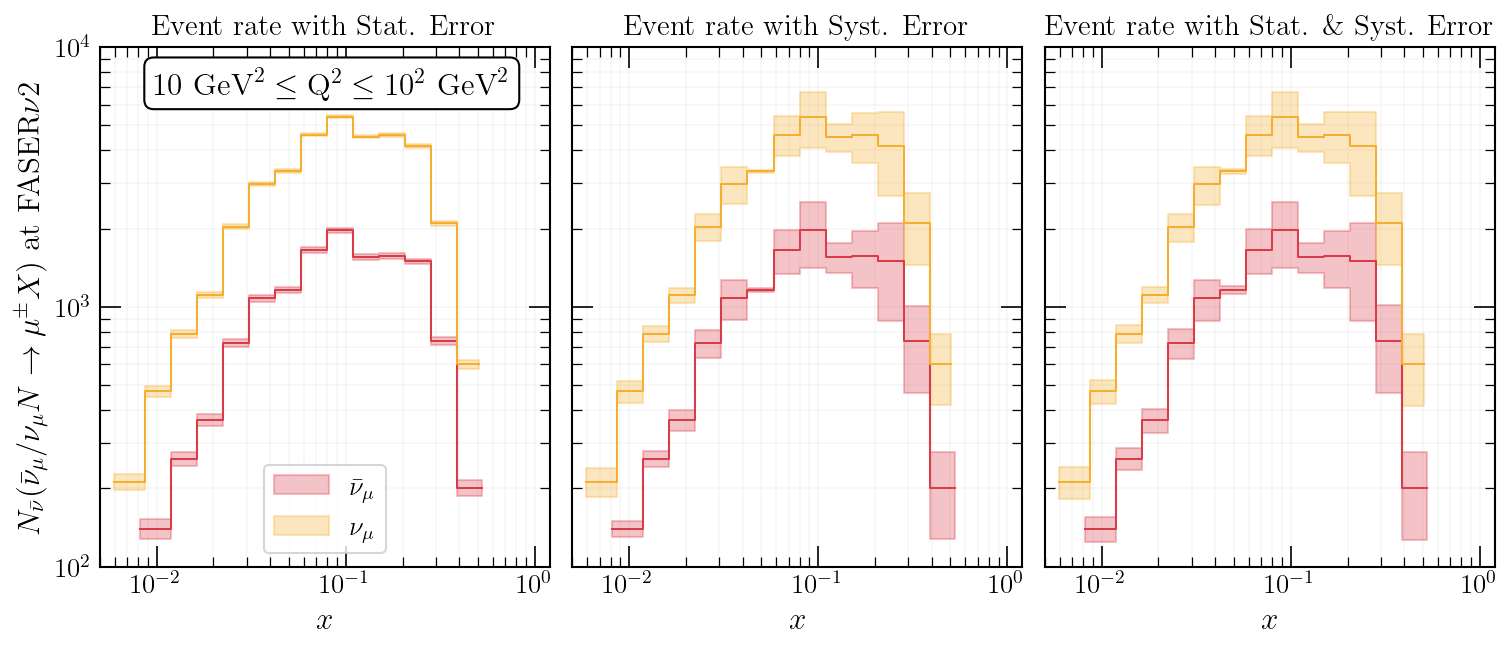

In [33]:
def runplotter():
    #choose some ploting, experiment, neutrino, inclusive/charm, and which errors to plot
    # y limits are currently set at the bottom of make_plots.


    #select experiment {FASERv, FASERv2 , FLArE10 , FLArE100 , SND}
    experiment = 'FASERv2'

    #select neutrino type. This mostly affects the plotting title.The sign of the neutrino selects either nu or nubar of experiment
    #should be either {14,-14} for FASER and SND, and either {12,-12} for FLArE
    neutrino = -14

    #{inclusive , charm}
    processtype = 'inclusive'

    #plot this type of error : {sys , stat , both}, both adds them in quad
    plot_errs = 'sys'

    #plot and save to .../CHARM/plots/...pdf
    make_updated_plots(experiment,neutrino,processtype,plot_errs)
runplotter()